In [1]:
import torch
import os
import numpy as np
from tqdm import tqdm
from model import Vocaburary, TextGCN

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.axes._axes import Axes
from matplotlib.figure import Figure

from IPython.display import clear_output

import pickle

c:\Users\Wen2Tee5\Desktop\Postgraduate\final\finalEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EPOCH = 300
HIDDEN_DIM = 200
WINDOW_SIZE = range(2, 20 + 1)
SAVE_PATH = f'.\\result\\Window_Size_Effect.result'

In [3]:
dataset_names = {
    "20NewsGroup": "20NG",
    "MR":"mr",
    "Ohsumed":"ohsumed_single_23",
    "R52":"R52",
    "R8":"R8"
}
keys = [k for k in dataset_names.keys()]

In [4]:
w_results = {
    k:{
        'WINDOW_SIZE':[],
        'BEST_ACC': []
       }
       for k in keys
}

In [5]:
if not os.path.isfile(SAVE_PATH):
    for key in keys:
        clear_output()
        print(f'Current Dataset {key}')
        dir_name = dataset_names[key]
        for window_size in WINDOW_SIZE:
            dict_data = torch.load(f'./ProcessedData/{dir_name}/WholeGraphDict_w{window_size}.gh')
            voc : Vocaburary = dict_data['voc']
            whole_graph = dict_data['whole_graph'].cuda()
            word_num = dict_data['W']
            label_num = dict_data['L']
            doc_num = dict_data['D']
            train_mask = dict_data['train_mask'].cuda()
            doc_Y : torch.Tensor = dict_data['doc_Y'].cuda()
            word_Y : torch.Tensor = dict_data['word_Y'].T.cuda()
            label_Y : torch.Tensor = dict_data['label_Y'].cuda()
            train_words = list(dict_data['train_word'])
            test_words = list(dict_data['test_word'])
            train_words.sort()
            test_words.sort()
            train_num = train_mask.count_nonzero().cpu().item()
            test_num = doc_num - train_num
            log = {"ACC": [], "LOSS": []}
            model = TextGCN(whole_graph.shape[0], HIDDEN_DIM, label_num).cuda()
            optim = torch.optim.Adam(model.parameters(), lr=1e-3)
            loss_fn = torch.nn.CrossEntropyLoss()
            trainingProcess = tqdm(range(EPOCH), desc=f'Current Window Size = {window_size}')
            for epoch in trainingProcess:
                total_loss = 0.
                optim.zero_grad()
                y_hat = model(whole_graph)
                doc_Y_hat = y_hat[:doc_num]
                word_Y_hat = y_hat[doc_num:-label_num]
                label_Y_hat = y_hat[doc_num+word_num :]
                doc_loss = loss_fn(doc_Y_hat[train_mask], doc_Y[train_mask])
                word_loss = loss_fn(word_Y_hat[train_words], word_Y[train_words])
                label_loss = loss_fn(label_Y_hat, label_Y)
                loss = 1.0 * doc_loss + 1.0 * word_loss  + 1.0 * label_loss
                loss.backward()
                optim.step()
                loss_val = loss.item()
                with torch.no_grad():
                    acc_val = ((doc_Y_hat.argmax(1)[~train_mask] == doc_Y.cuda()[~train_mask]).sum() / (~train_mask).sum()).item()
                trainingProcess.set_postfix({"LOSS": loss_val, "Accuracy":acc_val})
                log['ACC'].append(acc_val)
                log["LOSS"].append(loss_val)
            w_results[key]["WINDOW_SIZE"].append(window_size)
            w_results[key]["BEST_ACC"].append(max(log['ACC']))
    with open(SAVE_PATH, 'wb') as f:
        pickle.dump(w_results, f)
else:
    with open(SAVE_PATH, 'rb') as f:
        w_results = pickle.load(f)

In [6]:
w_results['MR']['BEST_ACC'] = np.array(w_results['MR']['BEST_ACC']) * 100
w_results['MR']['WINDOW_SIZE'] = np.array(w_results['MR']['WINDOW_SIZE'])

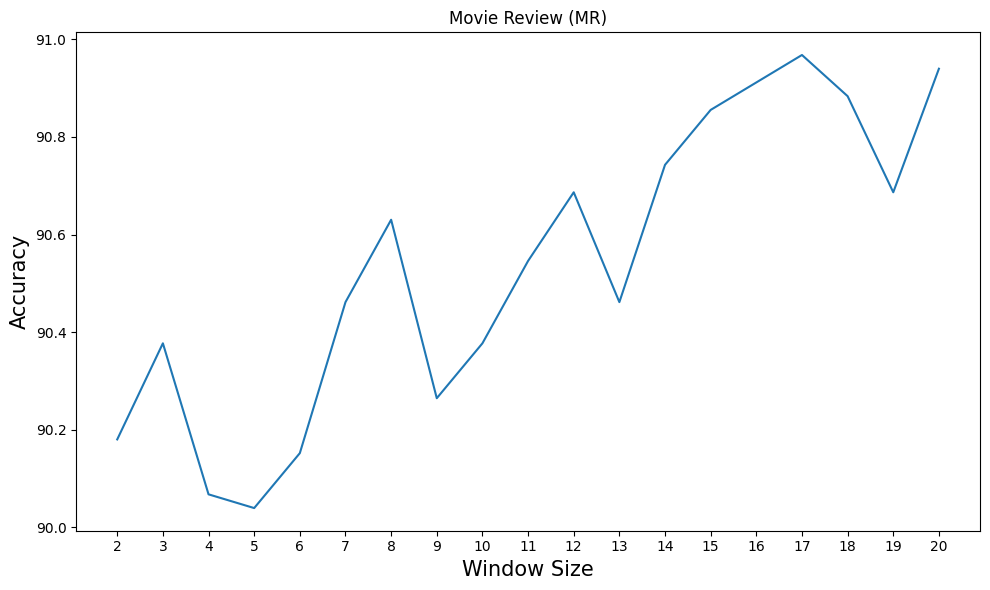

In [7]:
fig : Figure = plt.figure(figsize=(10.,6.))
plt.title("Movie Review (MR)")
plt.plot(w_results['MR']['WINDOW_SIZE'], w_results['MR']['BEST_ACC'])
plt.xticks(w_results['MR']['WINDOW_SIZE'])
plt.xlabel('Window Size', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)   
fig.tight_layout()
plt.show()
fig.savefig('./result/MR_Window_size_effect.svg', transparent=True, format ='svg')

In [8]:
keys.remove('MR')

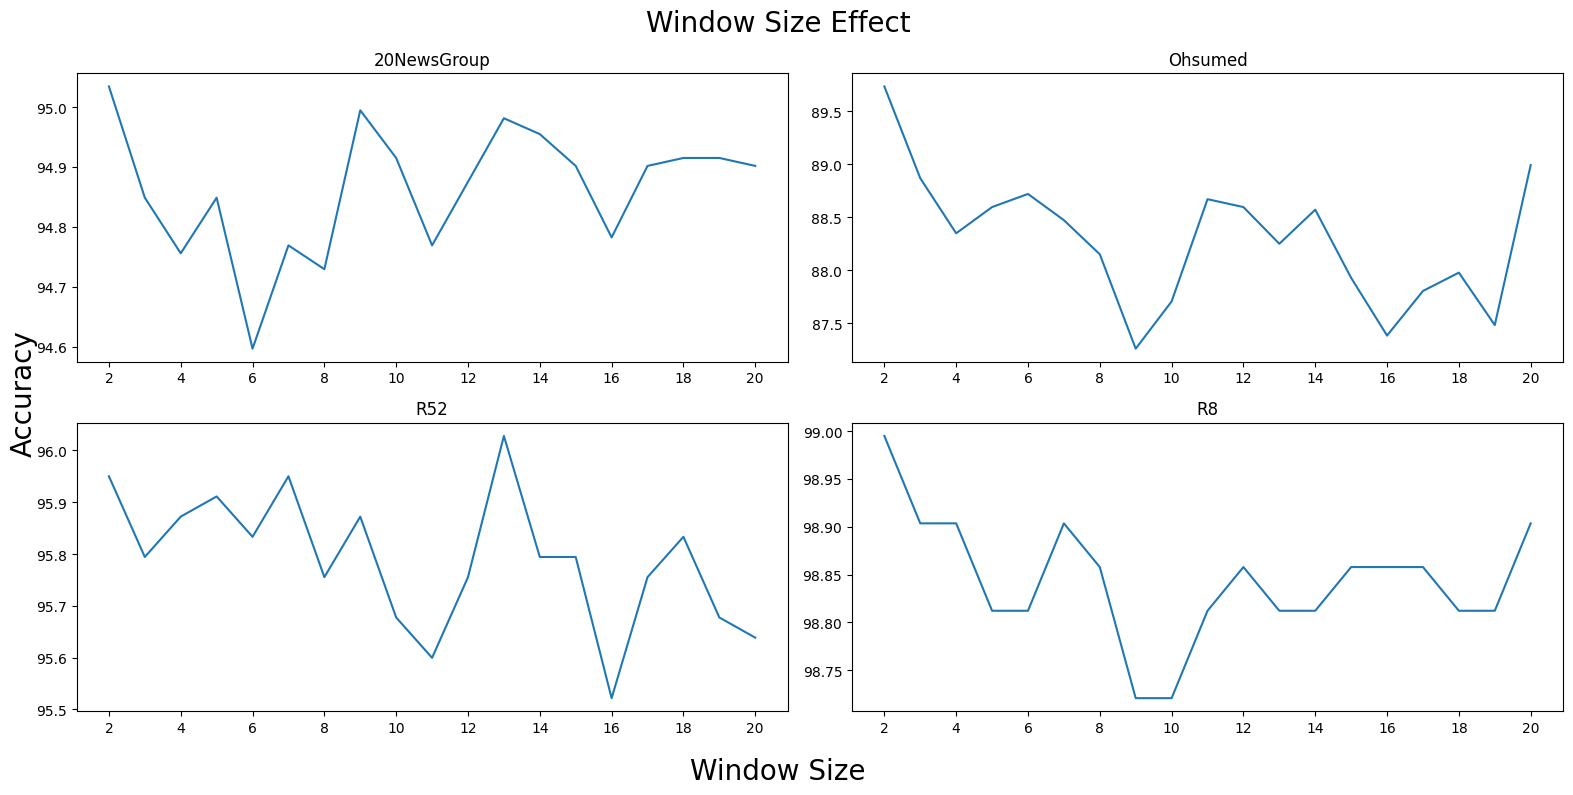

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
fig : Figure 
axs : np.ndarray[Axes]
for i, ax in enumerate(axs.flat):
    ax : Axes
    
    if i < 5:
        ax.set_title(keys[i])
        ax.plot(w_results[keys[i]]['WINDOW_SIZE'], list(map(lambda x : x * 100, w_results[keys[i]]['BEST_ACC'])))
        ax.xaxis.set_major_locator(locator=(MaxNLocator(integer = True)))
    else:
        ax.set_visible(False)
fig.set_alpha(0.0)
fig.supxlabel('Window Size', fontsize = 20)
fig.supylabel('Accuracy', fontsize = 20)   
fig.suptitle(t = "Window Size Effect", fontsize = 20)
fig.tight_layout()
fig.savefig('./result/Other_Window_size_effect.svg', transparent=True, format = 'svg')
plt.show()